In [1]:
%matplotlib widget

In [2]:
import os
import re
from collections import Counter

import pandas as pd
import numpy as np
import ast

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from dotenv import load_dotenv

from llama_index.embeddings.openai import OpenAIEmbedding

# from llama_index.core import (
#     load_index_from_storage,
#     StorageContext,
#     Document,
#     VectorStoreIndex,
#     get_response_synthesizer
# )

# from llama_index.core.retrievers import VectorIndexRetriever
# from llama_index.core.query_engine import RetrieverQueryEngine
# from llama_index.core.postprocessor import SimilarityPostprocessor

# from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
# from collections import defaultdict

In [3]:
df = pd.read_csv('../data/data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32294 entries, 0 to 32293
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         32294 non-null  int64 
 1   source     32294 non-null  object
 2   title      32294 non-null  object
 3   content    32294 non-null  object
 4   embedding  32294 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


In [4]:
df.head()

id source                                              title  \
0  33  tempo  Kapolri Instruksikan Proses Tegas Kasus Suap P...   
1  34  tempo  Terdampak Banjir, Mentan Siap Bantu Petani di ...   
2  35  tempo  Kementan Upayakan Perizinan Mudah, Cepat, dan ...   
3  36  tempo  Wapres Maruf Amin Dorong Pengusaha Sawit Perku...   
4  37  tempo  Menpan RB: Minat ASN Muda Pindah ke IKN Nusant...   

                                             content  \
0  TEMPO.CO, Yogyakarta- Kapolri Jenderal Listyo ...   
1  INFO NASIONAL - Menteri Pertanian Syahrul Yasi...   
2  INFO NASIONAL - Kementerian Pertanian memastik...   
3  INFO NASIONAL  Para pengusaha yang tergabung d...   
4  TEMPO.CO, Malang - Menteri Pendayagunaan Apara...   

                                           embedding  
0  [0.006670293,-0.008296051,0.018612592,-0.01163...  
1  [-0.013915301,-0.018322684,0.012273976,-0.0048...  
2  [0.015555209,-0.015595161,-0.001956054,-0.0336...  
3  [0.0035903626,-0.015759699,0.008853396,-0.0073...  
4  [-0.00013789257,-0.03197872,0.012931213,0.0022...

In [5]:
load_dotenv('var.env')

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

embed_model = OpenAIEmbedding()

In [6]:
df['embedding'] = df['embedding'].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))
X = np.array(df['embedding'].to_list(), dtype=np.float32)

In [7]:
X.shape

(32294, 1536)

In [8]:
tsne = TSNE(random_state=123, n_iter=1000)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['id'] = df['id']

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


C:\Users\USER\AppData\Local\Temp\ipykernel_3944\2143353776.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', palette='hls')


(-123.04985008239746,
 124.46390495300292,
 -127.38387832641601,
 125.52375564575195)

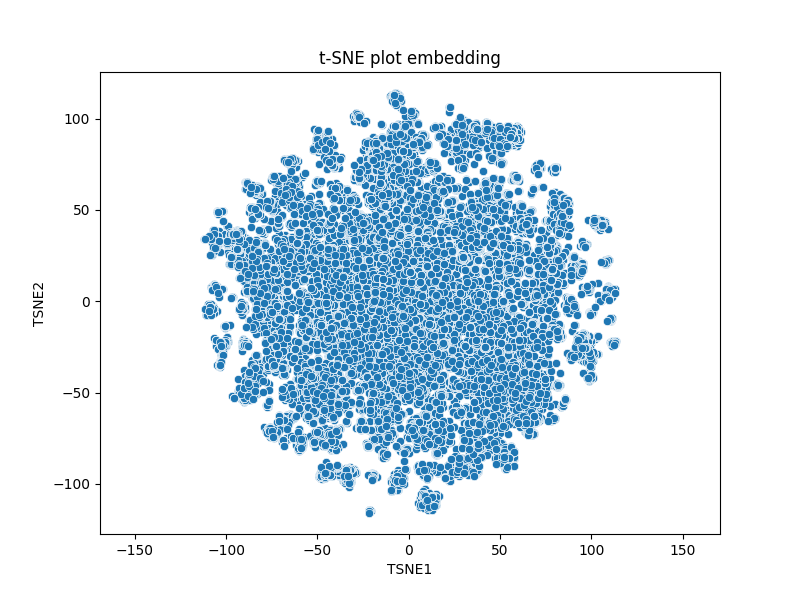

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', palette='hls')
plt.title('t-SNE plot embedding')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.axis('equal')

In [10]:
tsne = TSNE(n_components=3, random_state=123, n_iter=1000)
tsne_results = tsne.fit_transform(X)

df_tsne_3d = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2', 'TSNE3'])
df_tsne_3d['id'] = df['id']

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [11]:
random_df_tsne_3d_5000 = df_tsne_3d.sample(5000, random_state=123)

Text(0.5, 0.92, '3D t-SNE Visualization')

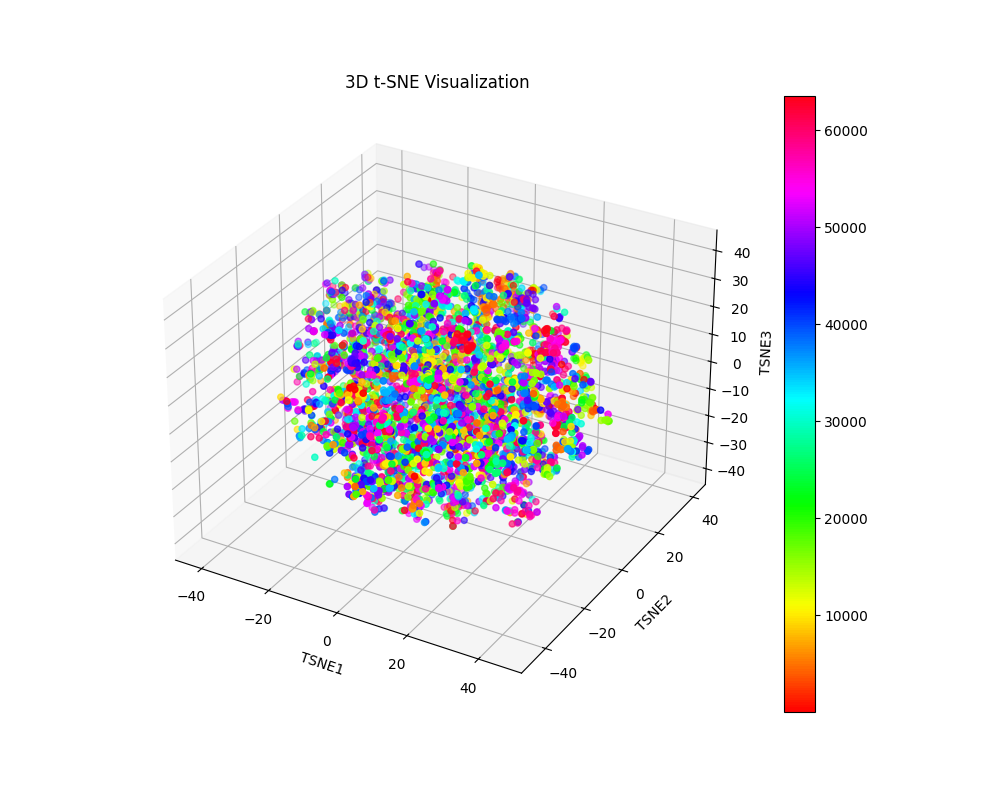

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(random_df_tsne_3d_5000['TSNE1'], random_df_tsne_3d_5000['TSNE2'], random_df_tsne_3d_5000['TSNE3'], c=random_df_tsne_3d_5000['id'], cmap='hsv') 
plt.colorbar(sc)
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('3D t-SNE Visualization')

In [13]:
inertia_values = []

k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

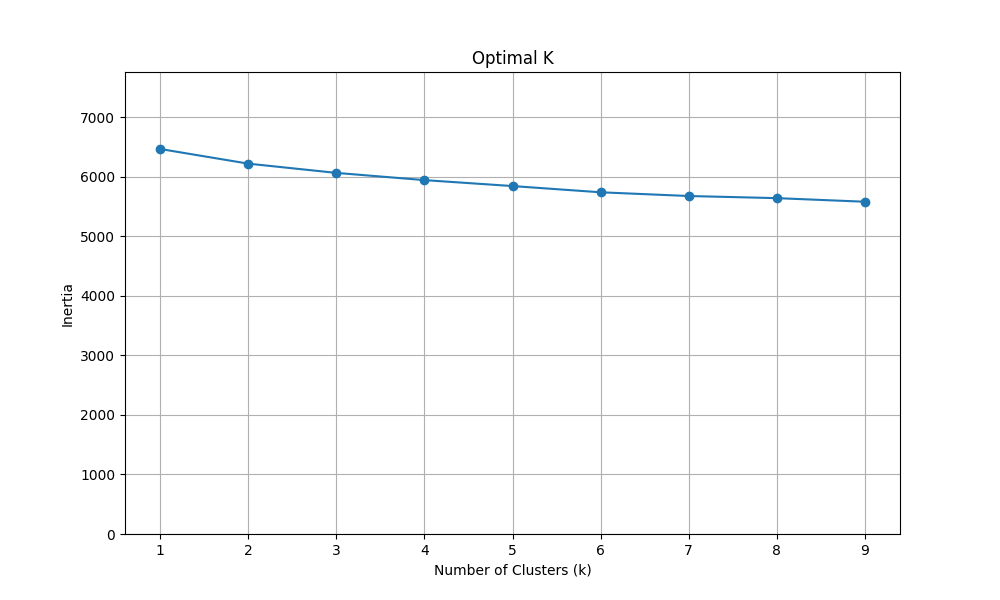

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)

plt.ylim(0, max(inertia_values) + (0.2 * max(inertia_values)))

plt.show()

In [108]:
n_clusters = 4


In [109]:
kmeans = KMeans(n_clusters=n_clusters, random_state=123).fit(X)

In [110]:
kmeans_labels = kmeans.labels_

In [111]:
print(kmeans_labels)

[0 2 1 ... 3 2 1]


In [112]:
df['cluster'] = kmeans_labels
df_tsne['cluster'] = kmeans_labels
df_tsne_3d['cluster'] = kmeans_labels

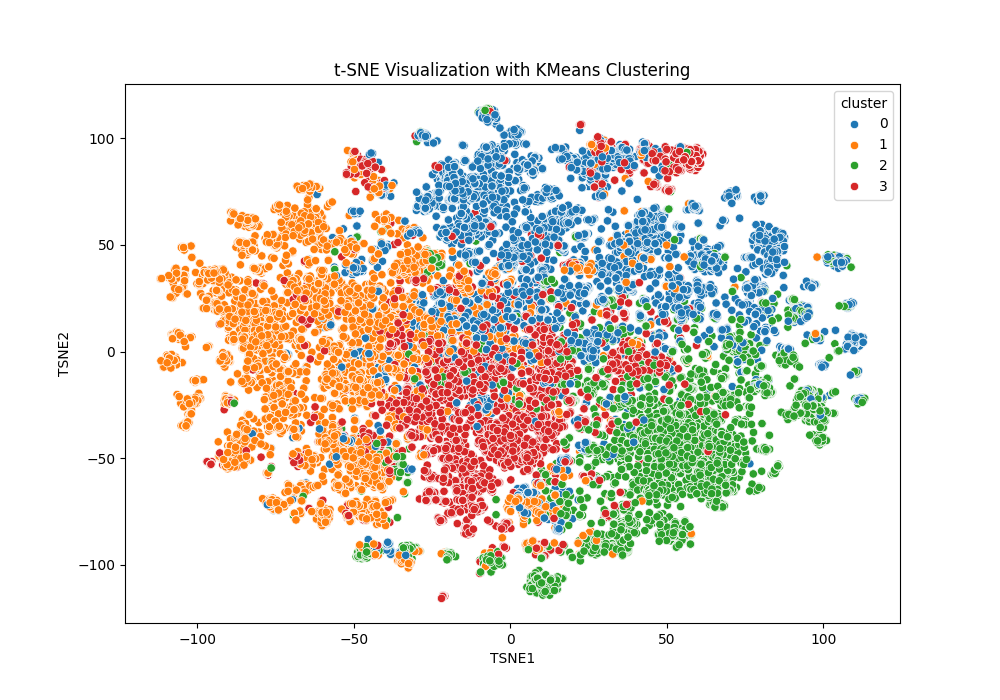

In [113]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='cluster',
    palette=sns.color_palette('tab10', n_clusters),
    data=df_tsne,
    legend='full'
)

plt.title('t-SNE Visualization with KMeans Clustering')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_3944\3538466420.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(df_tsne_3d['TSNE1'], df_tsne_3d['TSNE2'], df_tsne_3d['TSNE3'], c=cluster_colors, cmap='hsv')
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


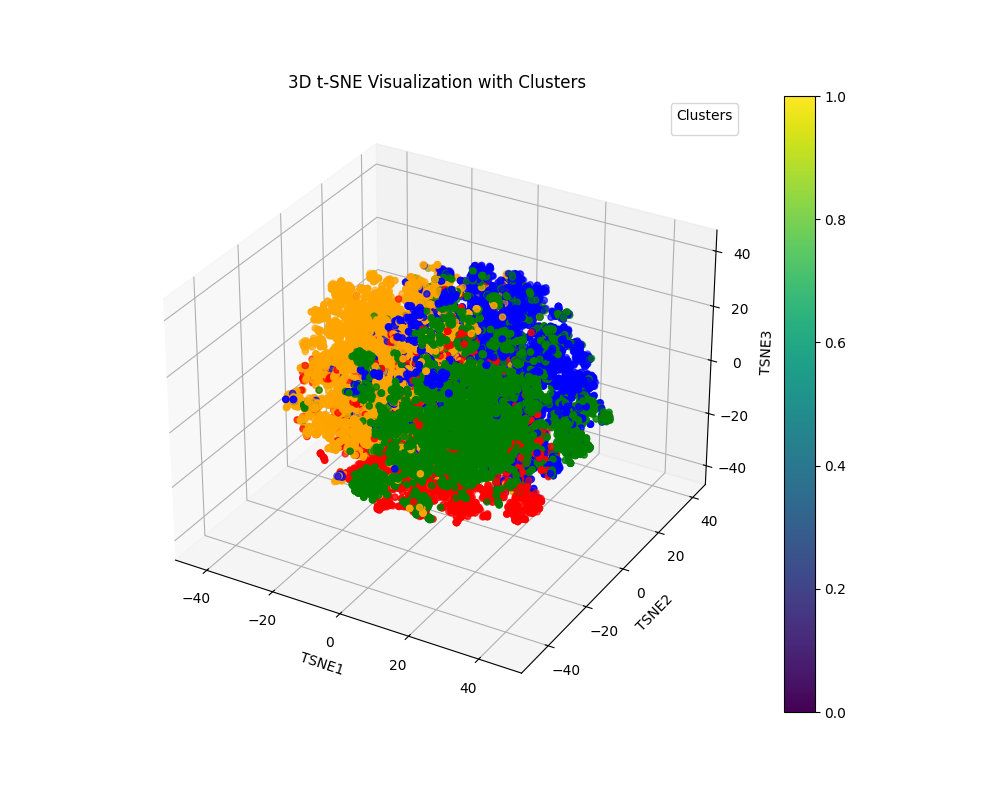

In [114]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'blue', 1: 'orange', 2: 'green',3:'red'}
cluster_colors = df_tsne_3d['cluster'].map(colors)

sc = ax.scatter(df_tsne_3d['TSNE1'], df_tsne_3d['TSNE2'], df_tsne_3d['TSNE3'], c=cluster_colors, cmap='hsv')
plt.colorbar(sc)
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('3D t-SNE Visualization with Clusters')

handles, labels = sc.legend_elements()
ax.legend(handles, [f'Cluster {i}' for i in range(n_clusters)], title="Clusters")

plt.show()

In [95]:
source_counts_total = df['source'].value_counts()
print(source_counts_total)

source
kumparan         8571
okezone          7066
cnbcindonesia    4506
suara            4004
tempo            3642
cnnindonesia     3491
jawapos          1014
Name: count, dtype: int64


In [96]:
source_counts_per_cluster = df.groupby(['cluster', 'source']).size().unstack(fill_value=0)
print(source_counts_per_cluster)

source   cnbcindonesia  cnnindonesia  jawapos  kumparan  okezone  suara  tempo
cluster                                                                       
0                  739          1529      391      1824     1911   1612   1817
1                 3450           715      277      1355     2121    771   1251
2                  155          1013      237      2205     2084    895    362
3                  162           234      109      3187      950    726    212


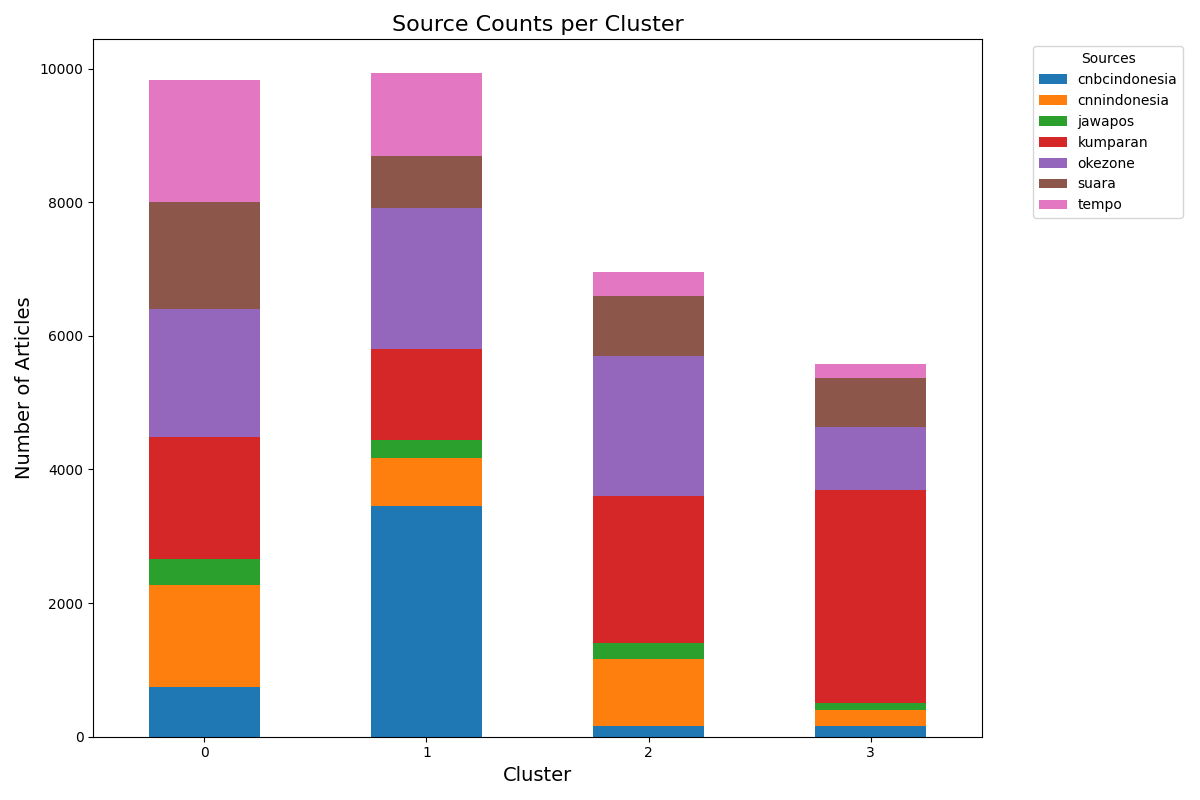

In [97]:
ax = source_counts_per_cluster.plot(kind='bar', stacked=True, figsize=(12, 8))
ax.set_title('Source Counts per Cluster', fontsize=16)
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Sources', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

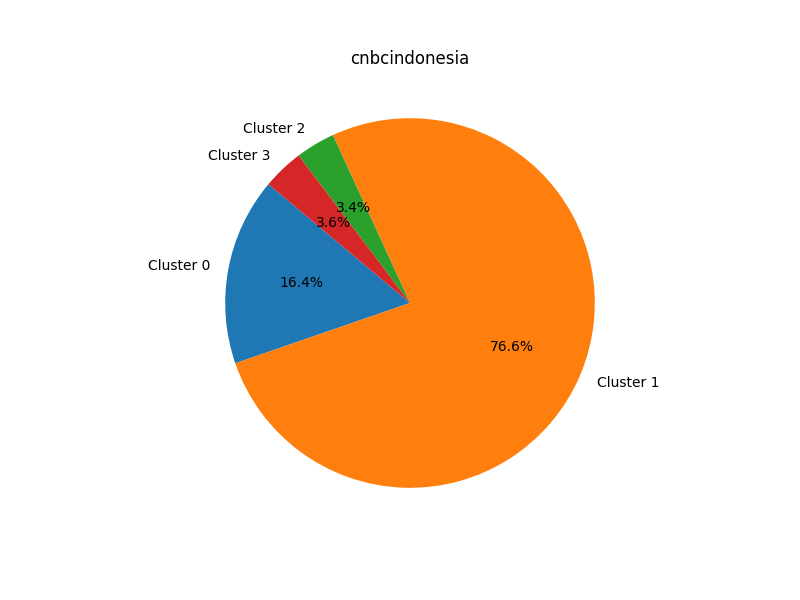

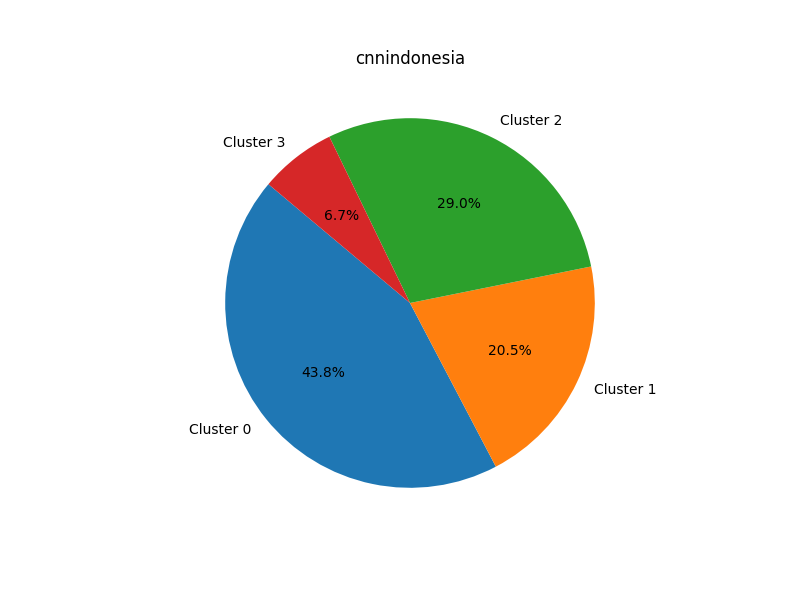

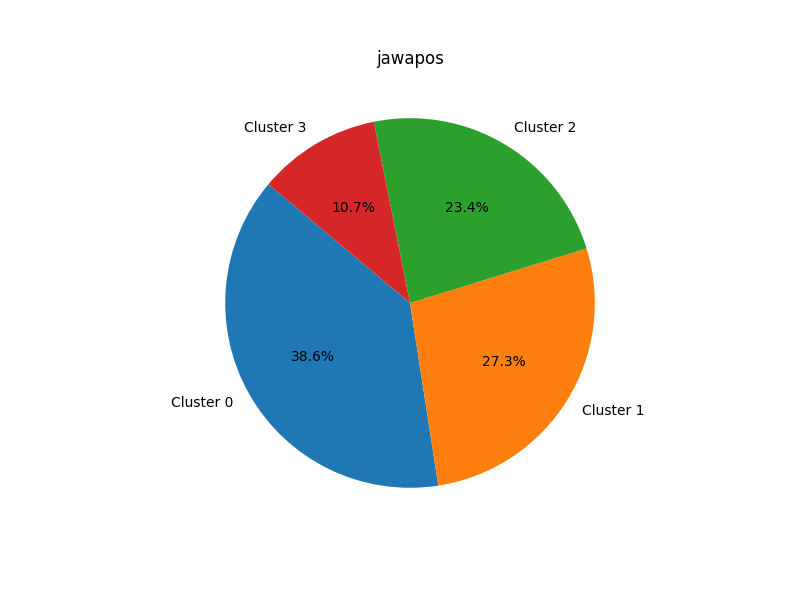

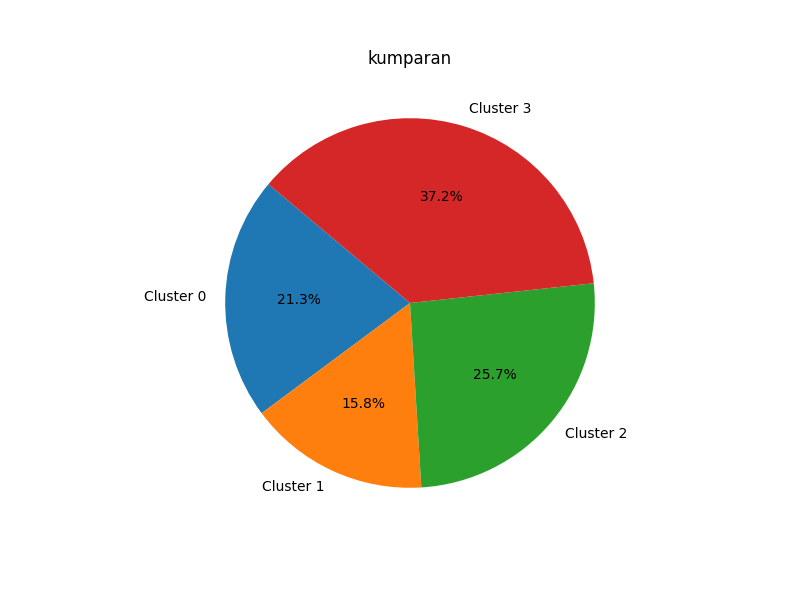

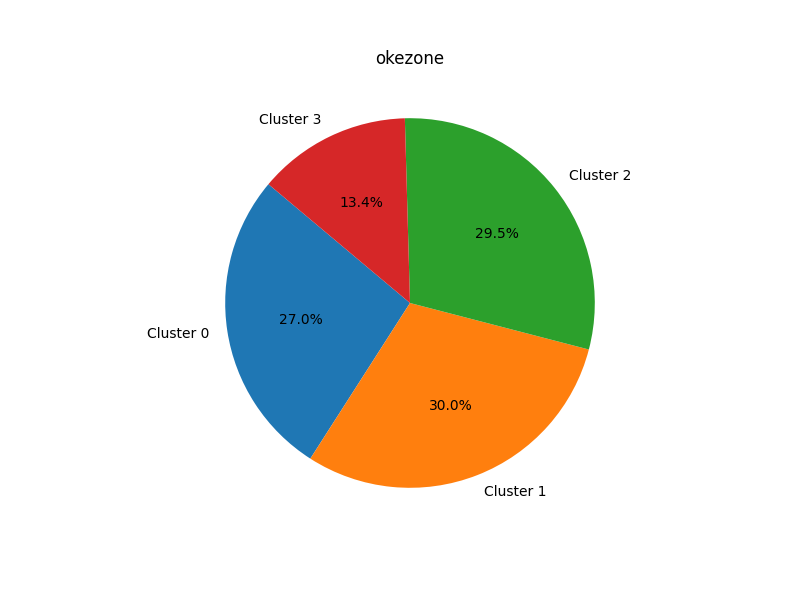

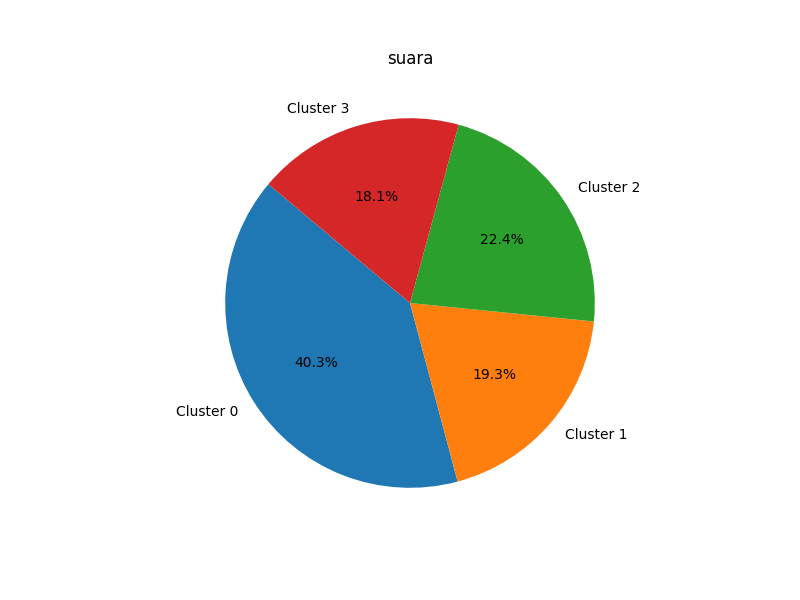

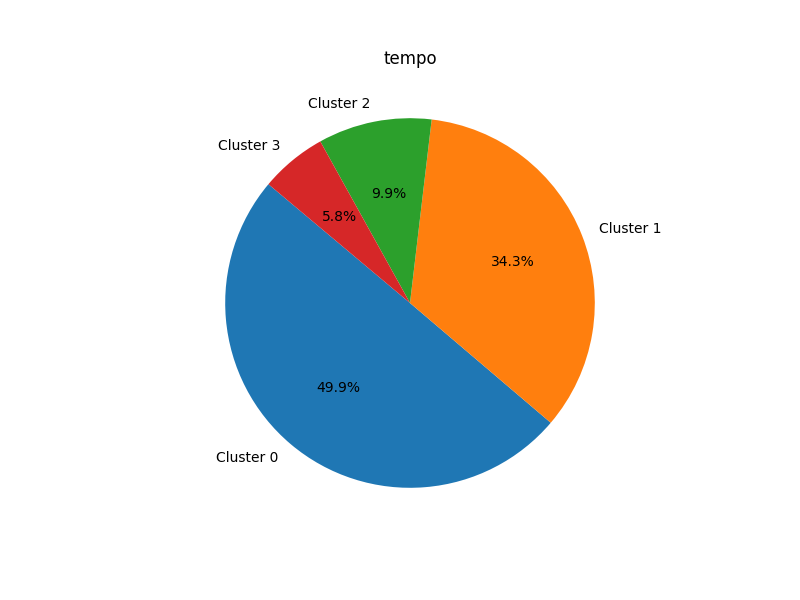

In [71]:
source_cluster_counts = pd.crosstab(df['source'], df['cluster'])

for source in source_cluster_counts.index:
    cluster_percentages = (source_cluster_counts.loc[source] / source_cluster_counts.loc[source].sum()) * 100
    
    plt.figure(figsize=(8, 6))
    plt.pie(
        cluster_percentages, 
        labels=[f'Cluster {i}' for i in range(n_clusters)], 
        autopct='%1.1f%%', 
        startangle=140
    )
    plt.title(source)
    plt.show()

In [72]:
source_majority_table = source_cluster_counts.idxmax(axis=1)

source_majority_table = source_majority_table.rename('Majority Cluster')

summary_table = pd.DataFrame({
    'Majority Cluster': source_majority_table,
    'Total Count': source_cluster_counts.sum(axis=1)
})

summary_table

Majority Cluster  Total Count
source                                      
cnbcindonesia                 1         4506
cnnindonesia                  0         3491
jawapos                       0         1014
kumparan                      3         8571
okezone                       1         7066
suara                         0         4004
tempo                         0         3642

In [29]:
stopwordpd =  pd.read_csv('../data/stopwordbahasa.csv')
stopwordlist = stopwordpd['stopwords'].to_list()

In [30]:
def preprocess_text(text, stopwordlist):
    text = str(text)

    text = text.lower()

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'(@\w+|#\w+)', '', text)

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'\s{2,}', ' ', text)
    
    words = text.split()
    words = [word for word in words if word not in stopwordlist]

    return words

In [115]:
cluster_word_counts = {}

In [116]:
for cluster in df['cluster'].unique():
    cluster_articles = df[df['cluster'] == cluster]['content']
    
    all_words = []
    for article in cluster_articles:
        all_words.extend(preprocess_text(article, stopwordlist))
    
    word_counts = Counter(all_words)
    cluster_word_counts[cluster] = word_counts

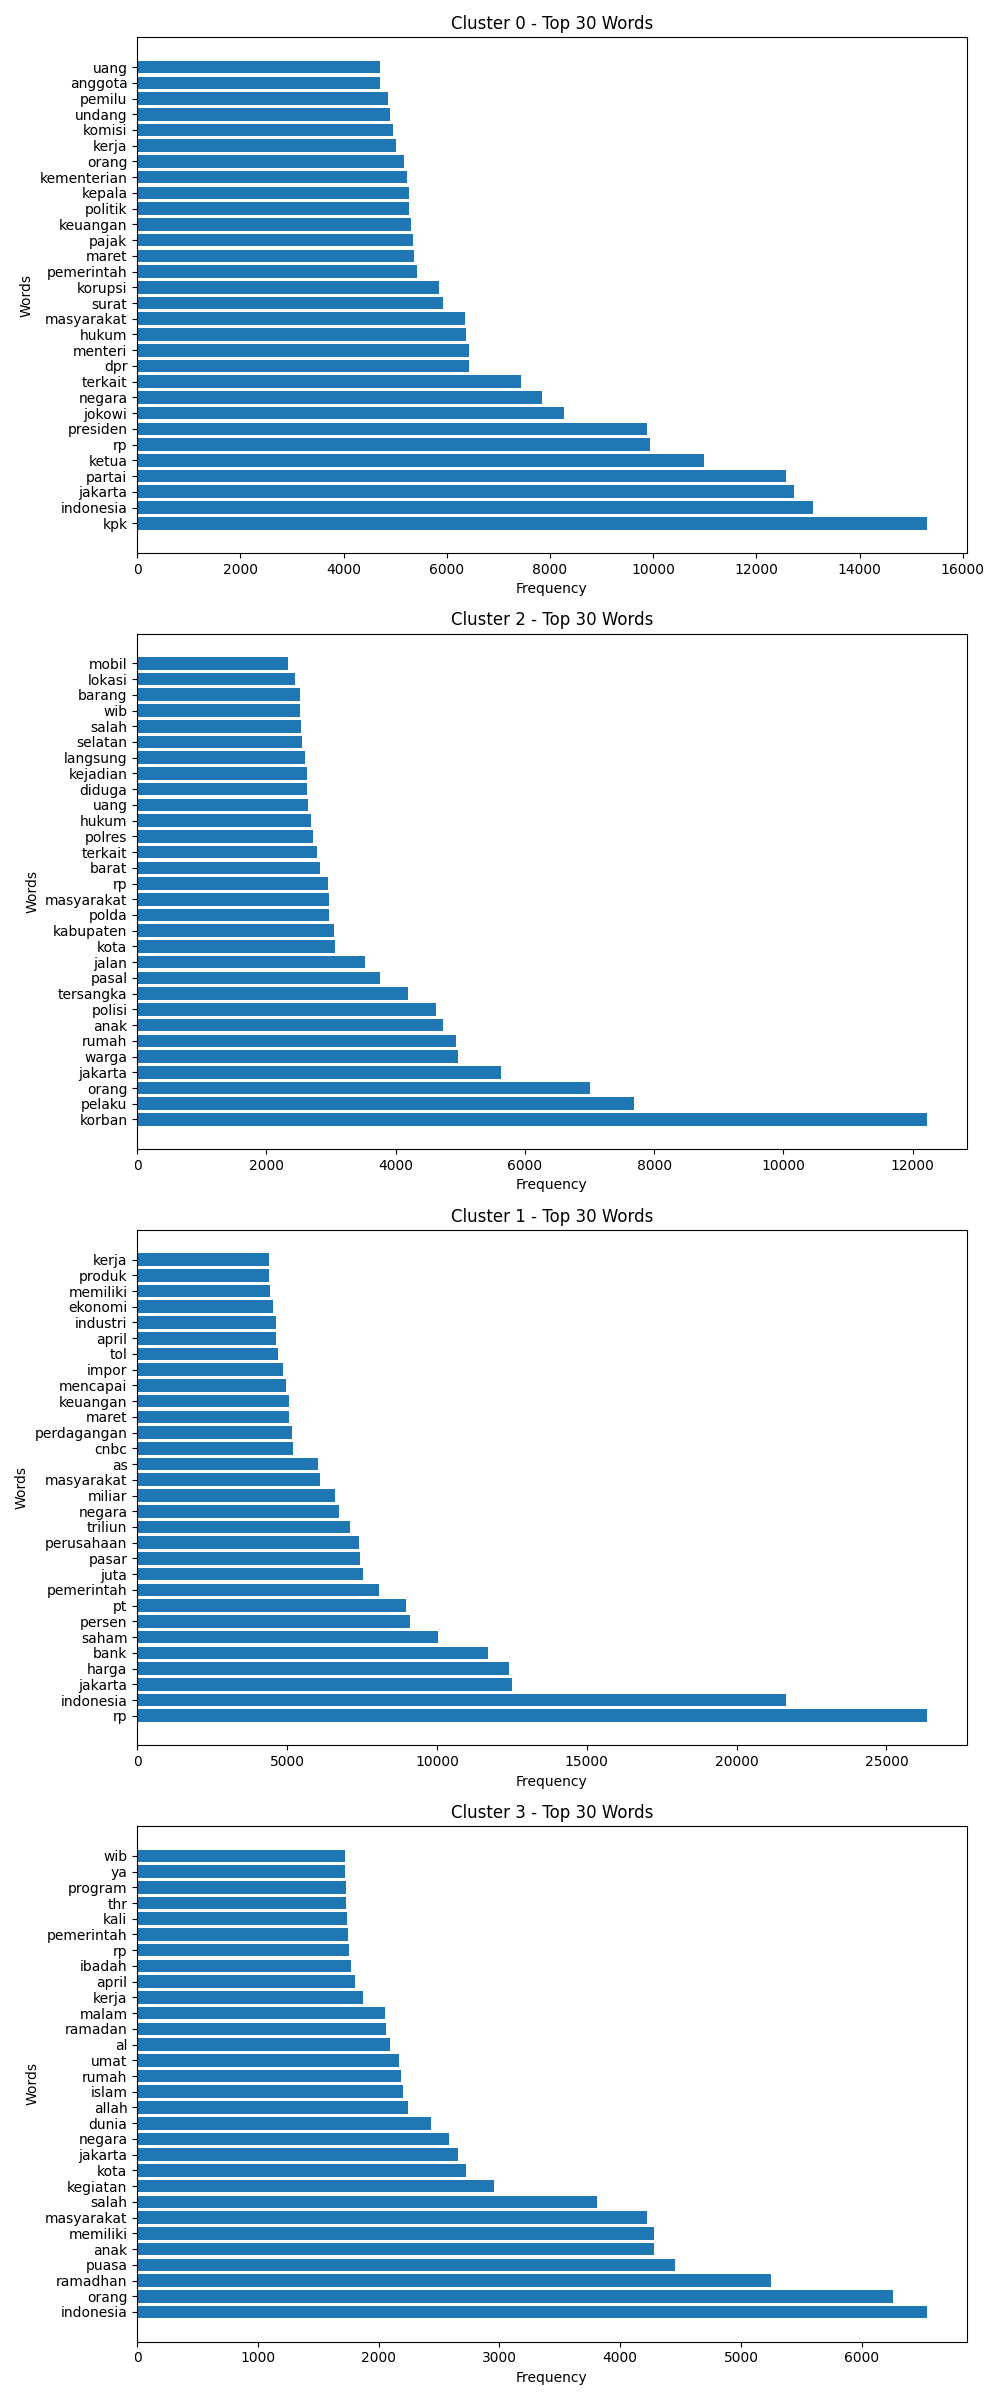

In [117]:
top_n = 30

fig, axes = plt.subplots(nrows=len(cluster_word_counts), figsize=(10, len(cluster_word_counts)*6))

for i, (cluster, word_counts) in enumerate(cluster_word_counts.items()):
    top_words = word_counts.most_common(top_n)
    words, counts = zip(*top_words)
    
    ax = axes[i] if len(cluster_word_counts) > 1 else axes
    ax.barh(words, counts)
    ax.set_title(f'Cluster {cluster} - Top {top_n} Words')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')

plt.tight_layout()
plt.show()

In [34]:
newText = """
Ibu Gregorius Ronald Tannur, Meirizka Widjaja telah tiba di Kejaksaan Agung (Kejagung RI) untuk dialkukan pemindahan penahanan setelah sebelumnya dilakukan di Surabaya setelah ditetapkan sebagai tersangka kasus dugaan suap demi vonis bebas Ronald Tannur dalam kasus tewasnya Dini Sera. Dia tiba di Kejagung dengan dibawa membawa mobil tahanan, Kamis (14/11/2024). Meirizka menggunakan rompi tahanan Kejaksaan Agung dengan tangan diborgol dan rambut terurai serta wajah tertutupi masker. Tidak satu kata pun yang disampaikan oleh Meirizka saat digelandang dari mobil menuju ke lift Gedung Kartika, Kejaksaan Agung. Meirizka ikut dipindahkan penahanan ke Jakarta setelah sebelumnya terlebih dahulu dilakukan oleh tiga hakim. Kepala Pusat Penerangan Hukum Kejagung Harli Siregar membenarkan adanya perpindahan penahanan terhadap Meirizka. Harli mengatakan pemindahan terhadap Meirizka dilakukan untuk mempermudah pemeriksaan terhadap Meirizka dalam perkara itu. Saat ini penyidik Kejagung terus melakukan pendalaman terkait aliran uang suap tersebut. "Untuk efektivitas penyidikan," ujar Harli. Sebelumnya, Kejaksaan Agung menetapkan Meirizka sebagai tersangka tersangka suap kepada para hakim melalui kuasa hukum Ronald Tannur, Lisa Rahmat. Meirizka sebelumnya memang memiliki kedekatan dengan Lisa sejak dibangku sekolah. Usai adanya persetujuan Lisa sebagai kuasa hukum dari terdakwa Ronald Tannur, Meirizka meminta Lisa untuk mengupayakan kasus hukum dari anaknya tersebut ke Pengadilan Negeri Surabaya. "Lisa menemui tersangka Zarof Ricar agar dapat memilih para hakim yang mengadili kasus anaknya tersebut," katanya. Dalam pertemuan antara Lisa dan para hakim yang akan mengurus kasus tersebut, Lisa mengajukan permintaan sejumlah uang yang akan diberikan kepada sejumlah hakim agar perkara Ronald Tannur dapat dibebaskan. Pada awal masa persidangan, Meirizka memberikan sejumlah uang senilai Rp1,5 miliar kepada Lisa sebagai biaya pengurusan kasus terpidana Ronald Tannur. Selanjutnya, Lisa juga menalangi uang biaya pengurusan kasus tersebut sebesar Rp2 miliar. “Totalnya Rp3,5 miliar. Terhadap uang tersebut menurut LR diberikan kepada majelis hakim yang mengadili perkara yang dimaksud,” ucap Qohar. Meirizka terbukti melanggar pasal 5 ayat 1 atau 6 ayat 1 huruf a juncto 18 UU No. 31 Tahun 1999 tentang tindak pidana korupsi sebagaimana diubah UU 20 Tahun 2001 perubahan 31 Tahun 1999 tentang tipikor juncto pasal 55 ayat 1 ke-1 KUHP.
"""

# sample = df.sample().values[0]
# print(sample)
# newText_embedding = sample[4]
# newText_embedding

In [35]:
newText_embedding = embed_model.get_text_embedding(newText)

In [39]:
np_newText_embedding = np.array(newText_embedding, dtype=np.float32).reshape(1,-1)

In [40]:
predicted_cluster = kmeans.predict(np_newText_embedding)[0]

In [41]:
predicted_cluster

0

In [42]:
cluster_center = np.array(kmeans.cluster_centers_[predicted_cluster]).reshape(1,-1)
cluster_center

array([[-0.00179457, -0.01526805,  0.00708676, ..., -0.00826091,
        -0.00457244, -0.00825788]], dtype=float32)

In [43]:
cluster_docs = df[df['cluster'] == predicted_cluster]

In [44]:
similarities = cosine_similarity(
    [newText_embedding],
    list(cluster_docs['embedding'])
).flatten()

In [45]:
top_5_indices = np.argsort(similarities)[-5:][::-1]

In [46]:
top_5_docs = cluster_docs.iloc[top_5_indices]
top_5_docs

id        source                                              title  \
11145  24554      kumparan  KPK Jerat Lagi Hakim Agung Gazalba Saleh Tersa...   
30395  61525  cnnindonesia           Jaksa Nyatakan Pikir-pikir atas Vonis AG   
26260  52993      kumparan  Populer: Perempuan A Dituntut 4 Tahun Penjara;...   
29908  60512      kumparan  Ryszard Sakit Hati Dilaporkan Tamara Bleszynsk...   
25815  52465  cnnindonesia  Kubu David Harap Hakim Vonis AG Sesuai Tuntuta...   

                                                 content  \
11145  kembali menjerat Hakim Agung sebagai tersangka...   
30395  Jaksa menyatakan sikap pikir-pikir atas vonis3...   
26260  Berbagai peristiwa penting dan menarik terjadi...   
29908  Sidang gugatan terhadap  kembali digelar di Pe...   
25815  Kuasa hukum Cristalino David Ozora , Mellisa A...   

                                               embedding  cluster  
11145  [-0.0045015393, 0.00836048, 0.015850773, -0.03...        0  
30395  [0.0048993733, -0.0048369817, 0.0051161014, -0...        0  
26260  [-0.014549548, -0.023075823, 0.0076160925, -0....        0  
29908  [0.00030634739, -0.01578909, 0.0059025567, -0....        0  
25815  [0.0094476035, -0.0027577318, -0.0068436237, -...        0

In [47]:
top_words_cluster = cluster_word_counts[predicted_cluster].most_common(100)
top_words = {word: count for word, count in top_words_cluster}

for word, count in list(top_words.items())[:10]:
    print(f"{word}: {count}")

kpk: 16642
jakarta: 14420
indonesia: 14187
partai: 12612
ketua: 11400
rp: 10821
presiden: 9820
terkait: 8560
negara: 8257
jokowi: 8060


In [48]:
new_article_words = preprocess_text(newText, stopwordlist)

new_article_word_counts = Counter(new_article_words)

common_words_counts = {word: new_article_word_counts[word] for word in new_article_words if word in top_words}
sorted_common_words_counts = sorted(common_words_counts.items(), key=lambda x: x[1], reverse=True)

print(f"Predicted Cluster: {predicted_cluster}")
print(f"Common words in the new article that match top words in Cluster {predicted_cluster}:")

if sorted_common_words_counts:
    for word, count in sorted_common_words_counts:
        print(f"{word}: {count} / {top_words[word]}")
else:
    print("No common words found")

Predicted Cluster: 0
Common words in the new article that match top words in Cluster 0:
hakim: 6 / 3876
uang: 5 / 5660
tersangka: 4 / 4076
hukum: 4 / 8010
perkara: 3 / 3165
rp: 3 / 10821
miliar: 3 / 3840
pasal: 2 / 4678
uu: 2 / 3080
ri: 1 / 4313
dugaan: 1 / 4767
jakarta: 1 / 14420
kepala: 1 / 5911
pusat: 1 / 3246
pemeriksaan: 1 / 2906
terkait: 1 / 8560
memiliki: 1 / 4582
negeri: 1 / 3875
tindak: 1 / 3887
pidana: 1 / 5170
korupsi: 1 / 6475


In [49]:
sample = df.sample().values[0]
print(sample)
newText_embedding = sample[4]
print(newText_embedding)

[4377 'tempo'
 'Perkuat Ketahanan Ekonomi Nasional Melalui Ekosistem Digital'
 'INFO NASIONAL  Ekonomi digital terus digaungkan Pemerintah sebagai upaya mempercepat transformasi ekonomi digital serta meningkatkan infrastruktur digital. Hal ini dikarenakan, Ekonomi Digital menjadi salah satu dari tiga isu prioritas yang diusung Indonesia dalam ASEAN 2023.Perkembangan transformasi digital terlihat dari geliat ekonomi digital, dimana di tahun 2022, nilai ekonomi digital Indonesia tercatat sebagai yang tertinggi di Asia Tenggara, yakni sebesar USD 77 miliar. Nilai tersebut setara dengan 40 persen pangsa pasar ekonomi internet ASEAN. Urgensi dari transformasi digital juga kian diperkuat dengan prediksi potensi nilai ekonomi digital Indonesia yang akan mampu mencapai USD 130 miliar di tahun 2025.Untuk merealisasikan potensi tersebut, transformasi ekonomi digital yang inklusif perlu terus dipercepat guna mengurangi kesenjangan digital yang masih terjadi. Upaya tersebut dilakukan melalui pengu

In [50]:
newText = """
Presiden Filipina Filipina Ferdinand ‘Bongbong’ Marcos Jr menyampaikan terima kasih kepada Presiden RI Prabowo Subianto atas bebasnya Mary Jane Veloso. Kabar bebasnya Mary Jane disampaikan Bongbong lewat instragramnya, Rabu (20/10). Perempuan Filipina itu adalah terpidana mati kasus narkoba yang dipenjara di Lapas Perempuan kelas II B Yogyakarta. “Saya menyampaikan rasa terima kasih yang sebesar-besarnya kepada 𝘗𝘳𝘦𝘴𝘪𝘥𝘦𝘯 𝘗𝘳𝘢𝘣𝘰𝘸𝘰 𝘚𝘶𝘣𝘪𝘢𝘯𝘵𝘰 dan pemerintah Indonesia atas niat baik mereka,” kata Bongbong di instagram resminya. “Hasil ini merupakan cerminan kedalaman kemitraan negara kita dengan Indonesia, bersatu dalam komitmen bersama terhadap keadilan dan kasih sayang,” sambung dia. Bongbong menyebut, Mary Jane bebas berkat diplomasi dan konsultasi pemerintahnya dengan Pemerintah Indonesia. Bahkan sebelum bebas, Bongbong menekankan Filipina berhasil menunda eksekusi matinya. “Kami berhasil menunda eksekusi matinya cukup lama demi mencapai kesepakatan untuk akhirnya membawanya pulang ke Filipina,” jelas dia. Bongbong mengatakan, Mary Jane akan segera kembali ke Filipina. Tetapi, dia tak mengungkap kapan pemulangan Mary Jane terwujud.
"""
newText_embedding = embed_model.get_text_embedding(newText)

In [51]:
np_newText_embedding = np.array(newText_embedding, dtype=np.float32).reshape(1,-1)
predicted_cluster = kmeans.predict(np_newText_embedding)[0]
predicted_cluster

0

In [52]:
similarities = cosine_similarity(
    [newText_embedding],
    list(df['embedding'])
)

In [53]:
similarities = list(enumerate(similarities[0]))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
similarities = similarities[:10]

In [54]:
pd.set_option('display.max_colwidth', None)

In [55]:
article_idx = [i[0] for i in similarities]
recommendations = df.iloc[article_idx][['title','source', 'cluster']]
recommendations

title  \
11754                                                    Soal Pembebasan Pilot Susi Air dari OPM, Jokowi Bilang Begini   
6407                       Polisi Gagalkan Keberangkatan 10 PMI Ilegal Modus 'Tour and Travel', Bamsoet Beri Apresiasi   
11568                                   Kapten Philips Masih Disandera KKB, Ini Kata Jokowi soal Langkah Pembebasannya   
4624                                            AKBP Dody Bersimpuh Sambil Menangis di Kaki Ayahnya dalam Ruang Sidang   
22328                              Viral Napi Lapas Bukittinggi Ngaku Bisnis Narkoba Bareng Linda, Terkenal di Penjara   
6670   Jokowi Apresiasi Warga Melayu-Banjar Ikut Dukung IKN Nusantara: Semoga Bisa Jadi Tuan Rumah di Tanahnya Sendiri   
7918                                    Salurkan Bantuan Presiden Jokowi, Polres Mabar Datangi Ponpes dan Panti Asuhan   
11741                             Evakuasi Pilot Susi Air Usai Disandera KKB, Jokowi: Hati-Hati Keselamatan yang Utama   
7515                      Dukung Pembangunan IKN, Jokowi: Masyarakat Melayu-Banjar Jadi Tuan Rumah di Tanahnya Sendiri   
17817                                           Syamsul Ma'arif Dituntut 17 Tahun Penjara Kasus Narkoba Teddy Minahasa   

              source  cluster  
11754  cnbcindonesia        0  
6407           suara        0  
11568        okezone        0  
4624         jawapos        0  
22328          suara        0  
6670           suara        0  
7918        kumparan        0  
11741        okezone        0  
7515         okezone        0  
17817        okezone        0

In [56]:
newText

'\nPresiden Filipina Filipina Ferdinand ‘Bongbong’ Marcos Jr menyampaikan terima kasih kepada Presiden RI Prabowo Subianto atas bebasnya Mary Jane Veloso. Kabar bebasnya Mary Jane disampaikan Bongbong lewat instragramnya, Rabu (20/10). Perempuan Filipina itu adalah terpidana mati kasus narkoba yang dipenjara di Lapas Perempuan kelas II B Yogyakarta. “Saya menyampaikan rasa terima kasih yang sebesar-besarnya kepada 𝘗𝘳𝘦𝘴𝘪𝘥𝘦𝘯 𝘗𝘳𝘢𝘣𝘰𝘸𝘰 𝘚𝘶𝘣𝘪𝘢𝘯𝘵𝘰 dan pemerintah Indonesia atas niat baik mereka,” kata Bongbong di instagram resminya. “Hasil ini merupakan cerminan kedalaman kemitraan negara kita dengan Indonesia, bersatu dalam komitmen bersama terhadap keadilan dan kasih sayang,” sambung dia. Bongbong menyebut, Mary Jane bebas berkat diplomasi dan konsultasi pemerintahnya dengan Pemerintah Indonesia. Bahkan sebelum bebas, Bongbong menekankan Filipina berhasil menunda eksekusi matinya. “Kami berhasil menunda eksekusi matinya cukup lama demi mencapai kesepakatan untuk akhirnya membawanya pulang ke 

In [57]:
correct_predictions = 0
total_samples = 100
increment = 10
accuracy_progress = []
matches_per_sample = []

In [58]:
for i in range(1, total_samples + 1):
    sample = df.sample().values[0]
    newText_embedding = sample[4]
    np_newText_embedding = np.array(newText_embedding, dtype=np.float32).reshape(1, -1)
    
    predicted_cluster = kmeans.predict(np_newText_embedding)[0]
    similarities = cosine_similarity([newText_embedding], list(df['embedding']))
    similarities = list(enumerate(similarities[0]))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]
    article_idx = [i[0] for i in similarities]
    recommendations = df.iloc[article_idx]
    
    recommended_clusters = recommendations['cluster'].values
    correct_predictions += np.sum(recommended_clusters == predicted_cluster)
    
    if i % increment == 0:
        accuracy = correct_predictions / (i * 10)  
        accuracy_progress.append((i, accuracy))

    matches = np.sum(recommended_clusters == predicted_cluster)
    matches_per_sample.append(matches)

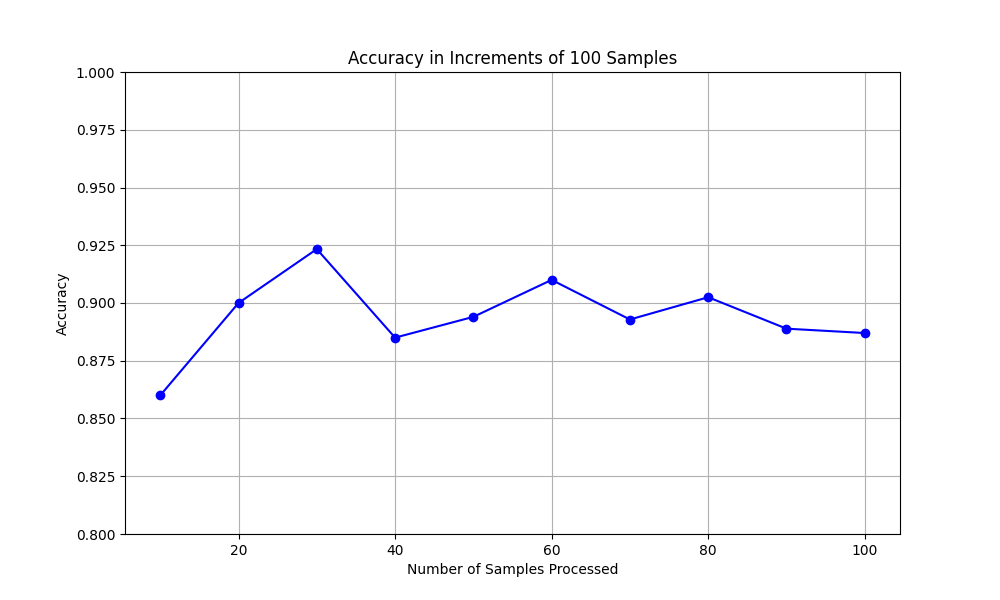

In [59]:
x = [point[0] for point in accuracy_progress]
y = [point[1] for point in accuracy_progress]

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title('Accuracy in Increments of 100 Samples')
plt.xlabel('Number of Samples Processed')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1)
plt.grid(True)
plt.show()

In [ ]:
# documents = []
# for index, row in df.iterrows():
#     document = Document(
#     text=row['content'],
#     doc_id=str(row['id']),
#     metadata={
#         'title': row['title'],
#     },
#     embedding=ast.literal_eval(row['embedding'])
#     )
#     documents.append(document)

# def createVectorIndex(documents):
#     index = VectorStoreIndex.from_documents(documents)
#     index.storage_context.persist(persist_dir="../storage")

# def loadVectorIndex():
#     storage_context = StorageContext.from_defaults(persist_dir="../storage")
#     index = load_index_from_storage(storage_context)
#     return index
# createVectorIndex(documents)
# index = loadVectorIndex()
# retriever = VectorIndexRetriever(
#     index=index,
#     similarity_top_k=10,
# )

# response_synthesizer = get_response_synthesizer()

# class CustomRetrieverQueryEngine(RetrieverQueryEngine):
#     def query(self, query_text: str):
#         retriever_results = self.retriever.retrieve(query_text)
        
#         print("Retrieved Documents with Bias Metadata:")
#         for doc in retriever_results:
#             print(doc)
#             print(doc.metadata['bias'])
#             print("-------")

#         return super().query(query_text)

# query_engine = CustomRetrieverQueryEngine(
#     retriever=retriever,
#     response_synthesizer=response_synthesizer,
#     node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.7)],
# )

# response = query_engine.query("What's this news about, and what's it's bias label? Explain why the bias label is so, and what it highlights that makes it get the bias label." + query_str)
# print(response)